In [3]:
import rasterio
import geopandas as gpd
import numpy as  np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.crs import CRS


In [4]:
red_path = '../data/raw/SR_B4.TIF'
nir_path = '../data/raw/SR_B5.TIF'
shape_path = '../data/raw/Pohjois-Savo.geojson'

In [7]:
# Open bands
with rasterio.open(red_path) as red_src, rasterio.open(nir_path) as nir_src:
    red = red_src.read(1).astype('float32')
    nir = nir_src.read(1).astype('float32')

    # check for invalid crs (EPSG:9001 or None)
    def fix_crs(src):
        if not src.crs or "9001" in str(src.crs):
            return CRS.from_epsg(32635)  
        return src.crs

    red_crs = fix_crs(red_src)
    nir_crs = fix_crs(nir_src)

    # Use red's CRS as base
    working_crs = red_crs

    # Load and reproject farm boundary
    farm_shape = gpd.read_file(shape_path)
    if farm_shape.crs is None:
        farm_shape.set_crs("EPSG:4326", inplace=True)
    farm_shape = farm_shape.to_crs(working_crs)

    # Clip raster bands
    clipped_red, _ = mask(red_src, farm_shape.geometry, crop=True)
    clipped_nir, _ = mask(nir_src, farm_shape.geometry, crop=True)

    # Recalculate NDVI
    ndvi_clipped = (clipped_nir[0] - clipped_red[0]) / (clipped_nir[0] + clipped_red[0])

C:\Users\aduko\AppData\Local\Temp\ipykernel_23652\1271917681.py:29: RuntimeWarning: invalid value encountered in divide
  ndvi_clipped = (clipped_nir[0] - clipped_red[0]) / (clipped_nir[0] + clipped_red[0])


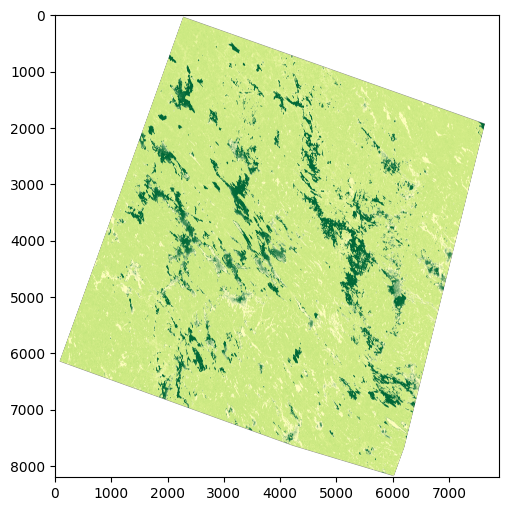

In [9]:
plt.figure(figsize=(8, 6))
img=plt.imshow(ndvi_clipped, cmap='RdYlGn', vmin=-1, vmax=1)

C:\Users\aduko\AppData\Local\Temp\ipykernel_23652\1950197738.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow((nir - red) / (nir + red), cmap='RdYlGn', vmin=-1, vmax=1)


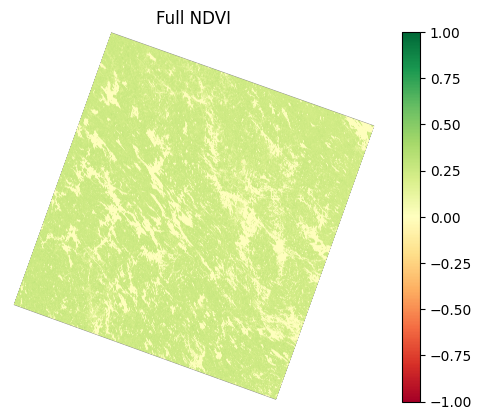

In [13]:
plt.imshow((nir - red) / (nir + red), cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar()
plt.title("Full NDVI")
plt.axis("off")
plt.show()

In [6]:
#classify values
def classify_ndvi(ndvi_array):
    classified = np.full(ndvi_array.shape, -1, dtype='int8') #-1 = no data
    classified[(ndvi_array >= -1) & (ndvi_array < 0.2)] = 0    # Barren / Water
    classified[(ndvi_array >= 0.2) & (ndvi_array <= 0.5)] = 1  # Moderate vegetation
    classified[(ndvi_array > 0.5) & (ndvi_array <= 1)] = 2   # Healthy / High Vegetaion
    return classified

# appling to ndvi array
classified_ndvi = classify_ndvi(ndvi_clipped)

In [7]:
import matplotlib.colors as mcolors

colors = ['skyblue', 'yellowgreen', 'darkgreen']
cmap = mcolors.ListedColormap(colors)
labels = ['Barren/Water', 'Moderate', 'Healthy']

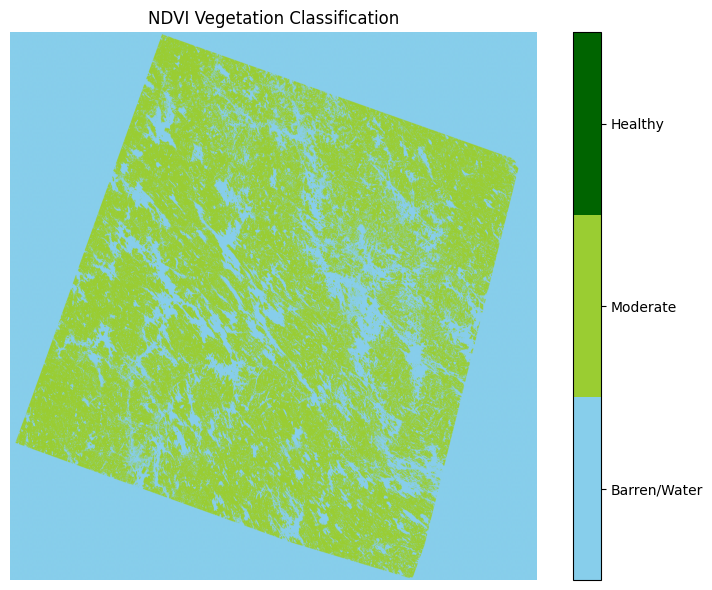

In [8]:
plt.figure(figsize=(8, 6))
img = plt.imshow(classified_ndvi, cmap=cmap, vmin=0, vmax=3)
cbar = plt.colorbar(img, ticks=[0.5, 1.5, 2.5])
cbar.ax.set_yticklabels(labels)
plt.title("NDVI Vegetation Classification")
plt.axis("off")
plt.tight_layout()
plt.show()

In [41]:
#Polygonizing the raster data
from rasterio.features import shapes
from shapely.geometry import shape

In [42]:
#extract trasnform from the original raster 
with rasterio.open(red_path) as src:
    transform = src.transform
    crs = src.crs

In [45]:
#generate dictionary (geometry, value) from classified ndvi
polygons = []
for geom, value in shapes(classified_ndvi, transform=transform):
    if value != -1:#skips no data
        polygons.append({"geometry": shape(geom), "value": int(value)})


#convert to geodataframe
gdf = gpd.GeoDataFrame(polygons, crs=crs)

#adding labels
gdf["label"] = gdf["value"].map({0: "Barren", 1: "Moderate", 2: "Healthy"})

#save as geojson
gdf.to_file("classified_ndvi_polygons.geojson", driver="GeoJSON")

#preview
gdf.head()

,geometry,value,label
0,"POLYGON ((447435 7092405, 447435 7092375, 4474...",0,Barren
1,"POLYGON ((447525 7092375, 447525 7092345, 4475...",1,Moderate
2,"POLYGON ((447255 7092225, 447255 7092195, 4472...",0,Barren
3,"POLYGON ((447945 7092225, 447945 7092195, 4479...",0,Barren
4,"POLYGON ((447705 7092285, 447705 7092255, 4477...",0,Barren


In [47]:
import os
os.path.exists("classified_ndvi_polygons.geojson")


True

In [49]:
#checking for valid shapes
print(gdf.is_valid.value_counts())

True    540275
Name: count, dtype: int64


In [53]:
#creating a .shp file
gdf.to_file("classified_ndvi_polygons.shp")


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'classified_ndvi_polygons.shp'

In [55]:
#create geopackage
gdf.to_file("classified_ndvi.gpkg", driver="GPKG")


In [57]:
#calculating the hectares
gdf["area_m2"] = gdf.geometry.area
gdf.groupby("label")["area_m2"].sum() / 10000 # hectares

label
Barren       821446.02
Healthy           1.26
Moderate    2383083.99
Name: area_m2, dtype: float64

In [59]:
#csv
stats = gdf.groupby("label")["area_m2"].sum().reset_index()
stats.to_csv("ndvi_zone_areas.csv", index=False)
